# Import libraries

In [37]:
import matplotlib.pyplot as plt
import numpy.matlib
import numpy as np
import scipy
from scipy.cluster.hierarchy import DisjointSet
from scipy.stats import truncnorm
import math

from network_def import *
from wk1_sampling import *
from wk1_histogram_plot import *
from wk1_6_complexity import *
from wk1_7_component import *
from wk2_1_config_model import *
from wk3_2_crit_thres import *
from wk3_4_SIR_djset import *



# Distributions of $\lambda_i$ for individual nodes

Generation of $\lambda_i$ arrays for each given $\lambda$ mean.

In [2]:
def node_lambda(n, mean, dist=None):
    """Generate the susceptibility for each node in the network."""
    # variance scale with mean value
    
    if dist is None:
        lambda_i = np.full(n, mean)
    elif dist == "uniform":
        lambda_i = np.random.uniform(0, 2*mean, n)
    elif dist == "normal":
        std = mean / 3
        lambda_i = np.random.normal(mean, std, n)
        lambda_i = np.clip(lambda_i, 0, 2*mean)
    elif dist == "exponential":
        lambda_i = np.random.exponential(mean, n)
        lambda_i = np.clip(lambda_i, 0, 1) # FIXME: after clipping, the mean is shifted to the left slightly
    else:
        raise ValueError("Invalid distribution type.")
    return lambda_i

def lambda_mat_gen(n, means, dist=None):
    """Generate the susceptibility matrix for each node in the network, for each value of lambda mean."""
    lambda_mat = np.empty((len(means),n))
    for idx, mean in enumerate(means):
        lambda_i = node_lambda(n, mean, dist)
        lambda_mat[idx] = lambda_i

    return lambda_mat # shape (len(means), n)


Prediction from iterative calculations of $s_i$ probabilities.

In [3]:
#### TODO: Modified from wk3_2_crit_thres to account for variations in the susceptibility of nodes (different lambda_i for each node)
def compute_s_probs(network, lambdas, tol=1e-6, max_iter=1000):
    n = network.n
    assert len(lambdas) == n, "Length of lambdas must equal to the number of nodes."
    adj_ls = network.adj_ls
    
    s = np.random.rand(n)
    s_prev = np.zeros(n)

    for _ in range(max_iter):
        if np.allclose(s, s_prev, atol=tol):
            break
        s_prev = s.copy()

        for i in range(n):
            s_j = np.array([s_prev[j] for j in adj_ls[i]])
            lambda_i = lambdas[i]
            log_terms = np.log(1 - lambda_i + s_j * lambda_i)
            s[i] = np.exp(np.sum(log_terms))

    return s # shape (n,)

Empirical simulations using DisjointSet.

In [4]:
#### TODO: Modified from wk3_4_SIR_djset to account for variations in the susceptibility of nodes (different lambda_i for each node) --> directional edges
def SIR_djset_dir(n, edge_ls, lambdas):
    """Simulate the SIR model on the given network represented by disjoint set.
    Assume single seed node to be node 0."""

    C = DisjointSet(range(n))
    edge_lambdas = np.array([lambdas[edge[0]] for edge in edge_ls]) # FIXME: (Simplifications) Assume the first node in the edge is the sink node (i.e. the node that can be infected)
    prob_infect = np.random.binomial(1, edge_lambdas) # Randomly assign infection outcome to each edge based on probability lambda_i (i.e., susceptibility of the sink node)
    
    for idx, edge in enumerate(edge_ls):
        if prob_infect[idx] == 1:
            C.merge(edge[0], edge[1])

    return C.subset_size(0) # Assume node 0 is the seed node

Set up experiments

In [5]:
# parameters
n = 10000
mean = 20
dists = [None, "uniform", "normal", "exponential"]
lambda_means = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25])

In [6]:
network = config_graph_gen(n, deg_dist_poisson(n, mean))
edge_ls = network.edge_list()
edge_ls = np.array(edge_ls)
# Shuffle the edge list along the edge pair axis
edge_ls = np.random.permutation(edge_ls)


In [7]:
lambda_mats = np.empty((len(dists), len(lambda_means), n))
for idx, dist in enumerate(dists):
    lambda_mats[idx] = lambda_mat_gen(n, lambda_means, dist) # shape (len(lambda_means), n)

In [8]:
# Check that the mean is relatively consistent across different distributions
lambda_means_actual = np.mean(lambda_mats, axis=2)
print(lambda_means_actual)

[[0.01       0.02       0.03       0.04       0.05       0.075
  0.1        0.15       0.2        0.25      ]
 [0.0100384  0.02020788 0.03032412 0.04000398 0.04972673 0.07514122
  0.10074821 0.14927525 0.20008353 0.25213859]
 [0.0100112  0.01995904 0.03002653 0.04013376 0.05004877 0.07490682
  0.09987157 0.15056517 0.19941591 0.24893929]
 [0.00978344 0.01987628 0.02978486 0.0403175  0.04975651 0.07424666
  0.09920533 0.14810682 0.19809872 0.24760954]]


Variance

[[0.00000000e+00 0.00000000e+00 1.92592994e-34 0.00000000e+00
  4.81482486e-35 1.92592994e-34 1.92592994e-34 7.70371978e-34
  7.70371978e-34 0.00000000e+00]
 [3.33001284e-05 1.32939445e-04 2.96363735e-04 5.27363529e-04
  8.30097032e-04 1.87294442e-03 3.29354306e-03 7.48686138e-03
  1.32454805e-02 2.09548597e-02]
 [1.09877800e-05 4.45491213e-05 9.72913604e-05 1.78469282e-04
  2.68731310e-04 6.11988589e-04 1.08303890e-03 2.46943812e-03
  4.42382518e-03 6.82283537e-03]
 [9.35248718e-05 3.85398370e-04 8.92571349e-04 1.58999334e-03
  2.51302838e-03 5.34083321e-03 9.58030230e-03 2.05897803e-02
  3.69168225e-02 5.38969784e-02]]


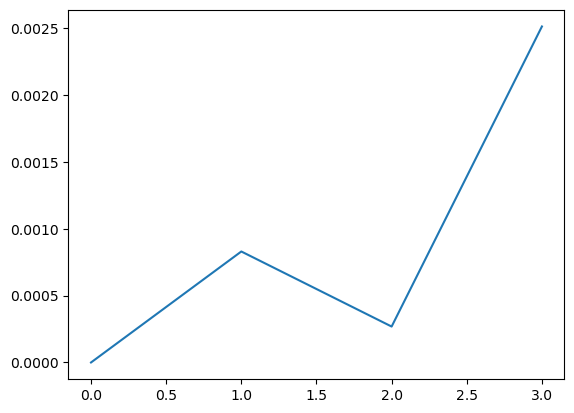

In [9]:
lambda_var = np.var(lambda_mats, axis=2)
print(lambda_var)
plt.plot(lambda_var[:,4])

Visualising Lambda distribution

[0.05       0.04972673 0.05004877 0.04975651]


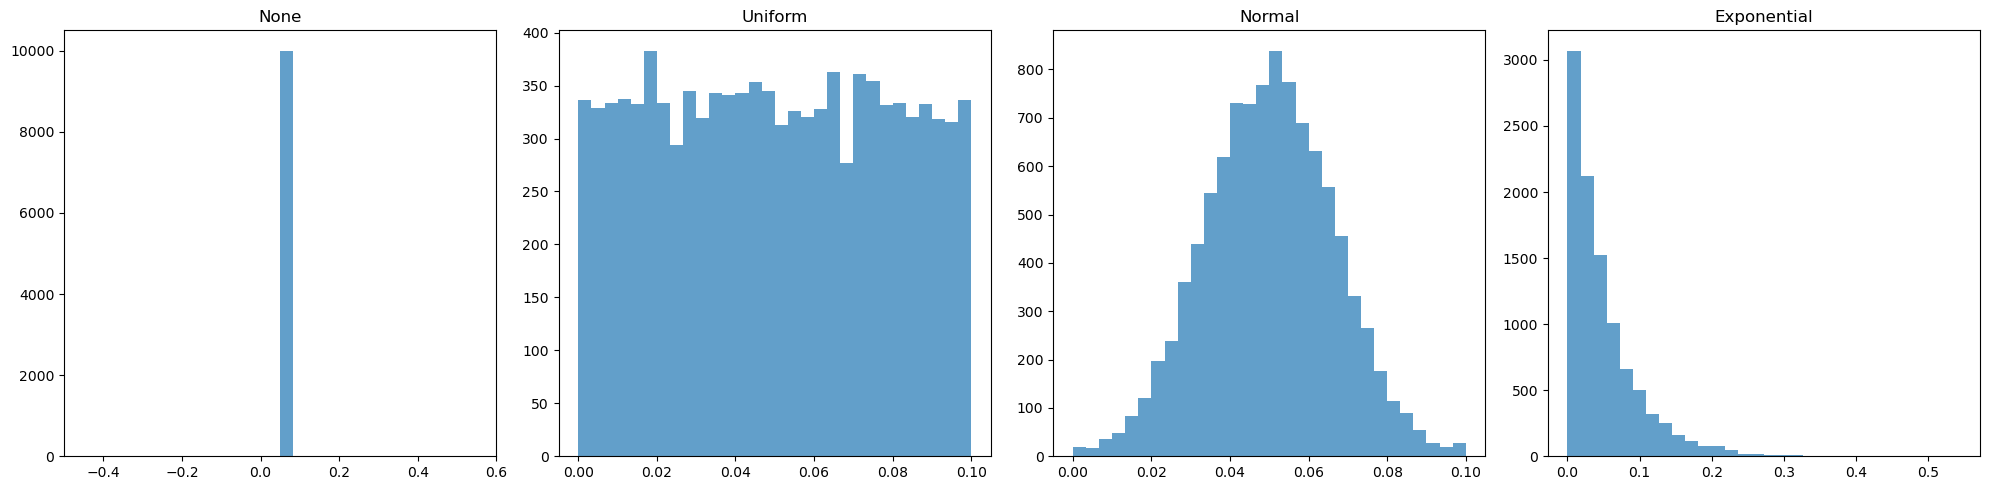

In [10]:
print(lambda_means_actual[:,4])
# Create 1x4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot each histogram in its respective subplot
axes[0].hist(lambda_mats[0, 4, :], bins=30, alpha=0.7, label = 'None')
axes[0].set_title('None')

axes[1].hist(lambda_mats[1, 4, :], bins=30, alpha=0.7, label = 'Uniform')
axes[1].set_title('Uniform')

axes[2].hist(lambda_mats[2, 4, :], bins=30, alpha=0.7, label = 'Normal')
axes[2].set_title('Normal')

axes[3].hist(lambda_mats[3, 4, :], bins=30, alpha=0.7, label = 'Exponential')
axes[3].set_title('Exponential')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

Theoretical:

In [11]:
s_arys = np.zeros((len(dists), len(lambda_means)))


for idx1, dist in enumerate(dists): # loop over each particular distribution
    lambda_mat = lambda_mats[idx1] 
    s_ary = s_arys[idx1]
    print(f"Processing dist: {dist}")
    
    for idx2, lambda_mean in enumerate(lambda_means): # select a particular lambda_mean
        print(f"lambda_mean = {lambda_mean}\r")
        lambdas = lambda_mat[idx2] # for a particular lambda_mean, get the corresponding lambda_i for all nodes in the network
        # print(lambdas.shape,"samples:", lambdas[:10])
        
        s_i = compute_s_probs(network, lambdas)
        s_ary[idx2] = np.average(s_i) # average over all nodes
        # print(f"Dist = {dist}, lambda_mean = {lambda_mean}, s = {s_ary[idx2]}")

    print(f"Dist = {dist}, s = {s_ary}")
Nr_arys_theo = n * (1 - s_arys)

Processing dist: None
lambda_mean = 0.01
lambda_mean = 0.02
lambda_mean = 0.03
lambda_mean = 0.04
lambda_mean = 0.05


KeyboardInterrupt: 

In [ ]:
# Data store 1:
# Nr_arys_theo = np.array([[3.58390187e-03, 2.18260270e-02, 8.38024797e-02, 2.57835281e-01, 9.23773792e+02, 8.06598930e+03, 9.42020311e+03, 9.80419665e+03, 9.93054364e+03], 
#                          [4.03927314e-03, 9.97570528e-03, 4.77433067e-02, 1.44114450e-01, 9.15229003e+02, 6.44989186e+03, 7.92367786e+03, 8.56591015e+03, 8.87225965e+03],
#                          [3.69227049e-03, 9.59461736e-03, 5.36946162e-02, 1.57161531e-01, 8.46966356e+02, 7.56607061e+03, 9.01585801e+03, 9.51488527e+03, 9.71293619e+03],
#                          [1.18795722e-03, 1.83912704e-03, 5.32576750e-03, 1.69301550e-02, 5.77993956e+02, 5.14556773e+03, 6.71280023e+03, 7.52918222e+03, 8.02006144e+03]])

# lambda_means_actual = np.array([[0.01,       0.02,       0.03,       0.04,       0.05,       0.1,
#   0.15,       0.2,        0.25      ],
#  [0.01005542, 0.01976755, 0.03004051, 0.03962072, 0.05014943, 0.09942733,
#   0.14937067, 0.20160109, 0.25130376],
#  [0.00997977, 0.01998708, 0.02991074, 0.04001799, 0.0498579,  0.10022147,
#   0.15005898, 0.19993539, 0.24918718],
#  [0.01015197, 0.02007289, 0.02988146, 0.03956198, 0.04968087, 0.09997815,
#   0.14868148, 0.19984373, 0.24595158]]) 

########################################################################################

# Data store 2:
# Nr_arys_theo = [[3.46539731e-03 2.09849811e-02 7.85452338e-02 2.22742855e-01
#   8.74323360e+02 6.07499212e+03 8.05021549e+03 9.41326636e+03
#   9.80092578e+03 9.92899745e+03]
#  [3.89391911e-03 8.78785932e-03 4.34636129e-02 1.17281605e-01
#   8.57123094e+02 4.78310170e+03 6.55602885e+03 7.89196266e+03
#   8.52419990e+03 8.89251787e+03]
#  [3.69901455e-03 9.62130071e-03 5.89585356e-02 1.83481096e-01
#   8.09970983e+02 5.55784624e+03 7.54994440e+03 8.98812004e+03
#   9.51271442e+03 9.73245238e+03]
#  [2.40462510e-04 2.96974370e-03 4.46671283e-03 1.81181255e-02
#   7.11875604e+02 3.55683569e+03 5.11312702e+03 6.74905781e+03
#   7.51907682e+03 8.04175786e+03]]

# lambda_means_actual = [[0.01       0.02       0.03       0.04       0.05       0.075
#   0.1        0.15       0.2        0.25      ]
#  [0.00994918 0.01982358 0.0300267  0.039453   0.0500487  0.0750896
#   0.10082602 0.14903359 0.19905047 0.25091861]
#  [0.01002273 0.020011   0.03012605 0.03994772 0.04982484 0.07461302
#   0.10006603 0.14897487 0.2006821  0.25002365]
#  [0.00999521 0.02011455 0.03017908 0.04101369 0.04953555 0.07475743
#   0.09938528 0.149787   0.19789762 0.24630209]]

In [ ]:
print(Nr_arys_theo)

[[3.46539731e-03 2.09849811e-02 7.85452338e-02 2.22742855e-01
  8.74323360e+02 6.07499212e+03 8.05021549e+03 9.41326636e+03
  9.80092578e+03 9.92899745e+03]
 [3.89391911e-03 8.78785932e-03 4.34636129e-02 1.17281605e-01
  8.57123094e+02 4.78310170e+03 6.55602885e+03 7.89196266e+03
  8.52419990e+03 8.89251787e+03]
 [3.69901455e-03 9.62130071e-03 5.89585356e-02 1.83481096e-01
  8.09970983e+02 5.55784624e+03 7.54994440e+03 8.98812004e+03
  9.51271442e+03 9.73245238e+03]
 [2.40462510e-04 2.96974370e-03 4.46671283e-03 1.81181255e-02
  7.11875604e+02 3.55683569e+03 5.11312702e+03 6.74905781e+03
  7.51907682e+03 8.04175786e+03]]


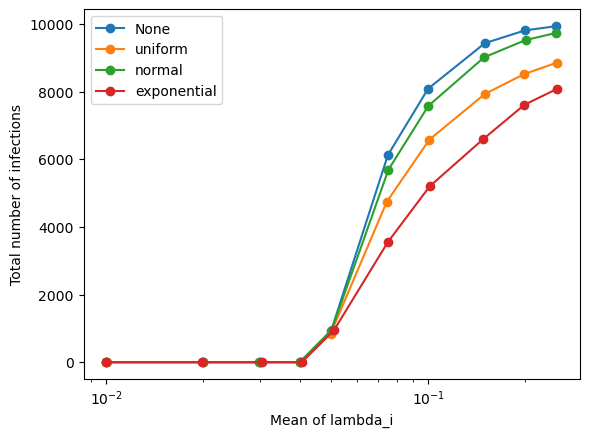

In [ ]:
# plot

plt.figure()
for idx, dist in enumerate(dists):
    plt.plot(lambda_means_actual[idx], Nr_arys_theo[idx], 'o-', label=f"{dist}")
plt.xlabel("Mean of lambda_i")
plt.xscale("log")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()

No impact on crit_thresholds.

Empirical:

In [ ]:
Nr_arys_emp = np.zeros((len(dists), len(lambda_means)))
Nr_covs_emp = np.zeros((len(dists), len(lambda_means)))
iter_n = 100
for idx1, dist in enumerate(dists):
    print("processing dist: ", dist)
    Nr_ary_emp = Nr_arys_emp[idx1]
    Nr_cov_emp = Nr_covs_emp[idx1]
    lambda_mat = lambda_mats[idx1]

    for idx2, lambdas in enumerate(lambda_mat):

        cluster_size = np.zeros(iter_n)
        for itn in range(iter_n):
            print("iter: ", itn, '/', iter_n, end='\r')
            edge_ls = np.random.permutation(edge_ls)
            cluster_size[itn] = SIR_djset_dir(n, edge_ls, lambdas)
        Nr_ary_emp[idx2] = np.mean(cluster_size)
        Nr_cov_emp[idx2] = np.std(cluster_size) / Nr_cov_emp[idx2]
        print(f"Dist = {dist}, lambda_mean = {lambda_means[idx2]}, Nr = {Nr_ary_emp[idx2]}")

processing dist:  None
Dist = None, lambda_mean = 0.01, Nr = 1.31


C:\Users\Sun Ruitong\AppData\Local\Temp\ipykernel_10752\1879838233.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  Nr_cov_emp[idx2] = np.std(cluster_size) / Nr_cov_emp[idx2]


Dist = None, lambda_mean = 0.02, Nr = 1.82
Dist = None, lambda_mean = 0.03, Nr = 2.63
Dist = None, lambda_mean = 0.04, Nr = 5.74
Dist = None, lambda_mean = 0.05, Nr = 59.54
Dist = None, lambda_mean = 0.075, Nr = 3875.51
Dist = None, lambda_mean = 0.1, Nr = 6544.59
Dist = None, lambda_mean = 0.15, Nr = 9228.13
Dist = None, lambda_mean = 0.2, Nr = 9709.06
Dist = None, lambda_mean = 0.25, Nr = 9932.29
processing dist:  uniform
Dist = uniform, lambda_mean = 0.01, Nr = 1.39
Dist = uniform, lambda_mean = 0.02, Nr = 1.88
Dist = uniform, lambda_mean = 0.03, Nr = 1.71
Dist = uniform, lambda_mean = 0.04, Nr = 11.68
Dist = uniform, lambda_mean = 0.05, Nr = 146.18
Dist = uniform, lambda_mean = 0.075, Nr = 477.08
Dist = uniform, lambda_mean = 0.1, Nr = 1319.38
Dist = uniform, lambda_mean = 0.15, Nr = 6910.85
Dist = uniform, lambda_mean = 0.2, Nr = 9508.86
Dist = uniform, lambda_mean = 0.25, Nr = 9726.48
processing dist:  normal
Dist = normal, lambda_mean = 0.01, Nr = 1.28
Dist = normal, lambda_mean

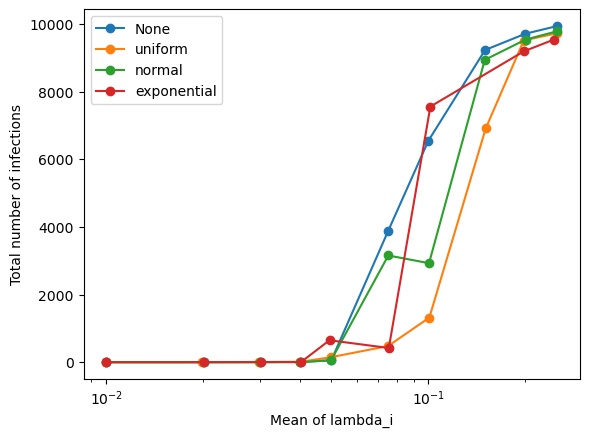

In [ ]:
# plot
plt.figure()
for idx, dist in enumerate(dists):
    if dist == "exponential":
        lambda_means_exp = np.delete(lambda_means_actual[idx], 7)
        Nr_arys_exp = np.delete(Nr_arys_emp[idx], 7)
        plt.plot(lambda_means_exp, Nr_arys_exp, 'o-', label=f"{dist}")
    else:
        plt.plot(lambda_means_actual[idx], Nr_arys_emp[idx], 'o-', label=f"{dist}")
plt.xlabel("Mean of lambda_i")
plt.xscale("log")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()

# Mask wearing
Introducing infection weights $w_s$, $w_i$, $w_d$

Let $p_m$ demote percentage of people wearing masks. <br>
Assume a constant $\lambda$ = 0.4. i.e. None distribution

In [25]:
# Setup
n = 10000
mean = 20
pm_ary = np.array([0.1, 0.5, 0.8])
lambda_ary = np.linspace(0.0, 0.3, 31)
iter_n = 100

In [ ]:
# Run the simulation without mask (original spread)
Nr_ary_nomask = np.zeros(len(lambda_ary))
Nr_covs_nomask = np.zeros(len(lambda_ary))

# Generate one single network and calculate the number of total infections for each lambda
for idx, lambda_ in enumerate(lambda_ary):
    print("processing lambda: ", lambda_)
    edge_ls = np.random.permutation(edge_ls) # Shuffle the edge list along the edge pair axis
    cluster_size = np.zeros(iter_n)
    for itn in range(iter_n):
        print("iter: ", itn, '/', iter_n, end='\r')
        cluster_size[itn] = SIR_djset(n, edge_ls, lambda_)
    mu = np.mean(cluster_size)
    Nr_ary_nomask[idx] = mu
    Nr_covs_nomask[idx] = np.std(cluster_size) / mu

The reduction in infection probability towards a susceptible person wearing masks be $w_s$ = 50%;<br>
The reduction in infection probability from an infectious person wearing masks be $w_i$ = 50%;<br>
The reduction in infection probability for both people wearing masks be $w_b$ = 80%.

In [26]:
w_s = 0.5 # only susceptible node wearing mask
w_i = 0.5 # only infected node wearing mask
w_b = 0.2 # both susceptible and infected nodes wearing mask 1-0.8 = 0.2
w = np.array([w_s, w_i, w_b])

In [27]:
def SIR_djset_mask(n, edge_ls, lambda_, pm, w):
    """Simulate the SIR model on the given network represented by disjoint set.
    Assume single seed node to be node 0.
    Giving the mask wearing probability for each node."""
    w_s, w_i, w_b = w

    # For a randomly chosen edge, probability of the 3 cases:
    pm_neither = (1-pm)**2 # neither of the nodes are wearing masks --> *1.0
    pm_single = 2*pm*(1-pm) # only 1 node is wearing mask #FIXME: how to determine if it's the source or sink node?? --> *w_s or *w_i
    pm_both = pm**2 # both nodes are wearing masks --> *w_b

    prob = np.array([pm_neither, pm_single/2, pm_single/2, pm_both]) # FIXME: Assume an edge has equal proability of being either direction
    weights = np.array([1.0, w_s, w_i, w_b])

    # For each edge, randomly choose a case based on the probability distribution
    lambdas_weighted = np.random.choice(weights, size=edge_ls.shape[0], p=prob) * lambda_
    # print(lambdas_weighted[:20])



    C = DisjointSet(range(n))
    
    prob_infect = np.random.binomial(1, p=lambdas_weighted) # Randomly assign infection outcome to each edge based on probability weighted lambda_i
    
    for idx, edge in enumerate(edge_ls):
        if prob_infect[idx] == 1:
            C.merge(edge[0], edge[1])

    return C.subset_size(0) # Assume node 0 is the seed node

In [29]:
# Simulations with mask
Nr_arys_mask = np.zeros((len(pm_ary), len(lambda_ary)))
Nr_covs_mask = np.zeros((len(pm_ary), len(lambda_ary)))


edge_ls = config_graph_edge_ls(n, deg_dist_poisson(n, mean))
for idx1, pm in enumerate(pm_ary):
    print("processing mask wearing proportion: ", pm)


    for idx2, lambda_ in enumerate(lambda_ary):
        print("processing lambda: ", lambda_)
        cluster_size = np.zeros(iter_n)

        for itn in range(iter_n):
            print("iter: ", itn, '/', iter_n, end='\r')
            edge_ls = np.random.permutation(edge_ls) # Shuffle the edge list along the edge pair axis
            cluster_size[itn] = SIR_djset_mask(n, edge_ls, lambda_, pm, w)
        mu = np.mean(cluster_size)
        Nr_arys_mask[idx1,idx2] = mu
        Nr_covs_mask[idx1,idx2] = np.std(cluster_size) / mu

        print(f"mask proportion = {pm}, lambda = {lambda_}, Nr = {mu}")

processing mask wearing proportion:  0.1
processing lambda:  0.0
mask proportion = 0.1, lambda = 0.0, Nr = 1.0
processing lambda:  0.01
mask proportion = 0.1, lambda = 0.01, Nr = 1.22
processing lambda:  0.02
mask proportion = 0.1, lambda = 0.02, Nr = 1.62
processing lambda:  0.03
mask proportion = 0.1, lambda = 0.03, Nr = 2.52
processing lambda:  0.04
mask proportion = 0.1, lambda = 0.04, Nr = 3.24
processing lambda:  0.05
mask proportion = 0.1, lambda = 0.05, Nr = 7.37
processing lambda:  0.06
mask proportion = 0.1, lambda = 0.06, Nr = 292.02
processing lambda:  0.07
mask proportion = 0.1, lambda = 0.07, Nr = 1481.69
processing lambda:  0.08
mask proportion = 0.1, lambda = 0.08, Nr = 2813.46
processing lambda:  0.09
mask proportion = 0.1, lambda = 0.09, Nr = 4763.83
processing lambda:  0.1
mask proportion = 0.1, lambda = 0.1, Nr = 4940.33
processing lambda:  0.11
mask proportion = 0.1, lambda = 0.11, Nr = 6757.78
processing lambda:  0.12
mask proportion = 0.1, lambda = 0.12, Nr = 737

In [45]:
# Data store 3:
'''Nr_ary_nomask = [1.00000e+00 1.27000e+00 1.67000e+00 2.42000e+00 4.60000e+00 5.26500e+01
 9.42980e+02 2.27835e+03 4.20314e+03 5.37899e+03 6.71242e+03 7.18865e+03
 7.83659e+03 8.51820e+03 9.06586e+03 9.31269e+03 9.24259e+03 9.43120e+03
 9.50364e+03 9.56494e+03 9.51044e+03 9.74249e+03 9.86891e+03 9.89386e+03
 9.91607e+03 9.93115e+03 9.94320e+03 9.95418e+03 9.96239e+03 9.96867e+03
 9.97464e+03]'''

'''Nr_arys_mask = [[1.00000e+00 1.22000e+00 1.62000e+00 2.52000e+00 3.24000e+00 7.37000e+00
  2.92020e+02 1.48169e+03 2.81346e+03 4.76383e+03 4.94033e+03 6.75778e+03
  7.37751e+03 8.19138e+03 8.25556e+03 8.80741e+03 9.23528e+03 8.88950e+03
  9.07407e+03 9.25002e+03 9.60029e+03 9.65767e+03 9.50270e+03 9.73434e+03
  9.66373e+03 9.88378e+03 9.90311e+03 9.92011e+03 9.93380e+03 9.94576e+03
  9.95413e+03]
 [1.00000e+00 1.11000e+00 1.28000e+00 1.66000e+00 1.80000e+00 2.39000e+00
  2.80000e+00 4.30000e+00 4.64000e+00 1.75300e+01 2.88740e+02 1.23595e+03
  1.99601e+03 2.91367e+03 4.35463e+03 4.50120e+03 5.32222e+03 6.23735e+03
  6.59510e+03 7.07123e+03 7.53019e+03 7.80705e+03 8.03494e+03 8.16645e+03
  8.20185e+03 8.93780e+03 8.84053e+03 8.64102e+03 9.17940e+03 9.23943e+03
  9.48490e+03]
 [1.00000e+00 1.05000e+00 1.11000e+00 1.42000e+00 1.55000e+00 1.26000e+00
  1.80000e+00 1.85000e+00 1.92000e+00 2.70000e+00 2.78000e+00 3.60000e+00
  4.52000e+00 6.87000e+00 8.30000e+00 3.16000e+01 1.34790e+02 3.14960e+02
  8.18040e+02 1.77144e+03 1.81942e+03 2.30825e+03 3.84023e+03 3.85305e+03
  4.66982e+03 4.13071e+03 5.29750e+03 4.93189e+03 5.53855e+03 5.85795e+03
  6.24653e+03]]'''


[1.00000e+00 1.27000e+00 1.67000e+00 2.42000e+00 4.60000e+00 5.26500e+01
 9.42980e+02 2.27835e+03 4.20314e+03 5.37899e+03 6.71242e+03 7.18865e+03
 7.83659e+03 8.51820e+03 9.06586e+03 9.31269e+03 9.24259e+03 9.43120e+03
 9.50364e+03 9.56494e+03 9.51044e+03 9.74249e+03 9.86891e+03 9.89386e+03
 9.91607e+03 9.93115e+03 9.94320e+03 9.95418e+03 9.96239e+03 9.96867e+03
 9.97464e+03]
[[1.00000e+00 1.22000e+00 1.62000e+00 2.52000e+00 3.24000e+00 7.37000e+00
  2.92020e+02 1.48169e+03 2.81346e+03 4.76383e+03 4.94033e+03 6.75778e+03
  7.37751e+03 8.19138e+03 8.25556e+03 8.80741e+03 9.23528e+03 8.88950e+03
  9.07407e+03 9.25002e+03 9.60029e+03 9.65767e+03 9.50270e+03 9.73434e+03
  9.66373e+03 9.88378e+03 9.90311e+03 9.92011e+03 9.93380e+03 9.94576e+03
  9.95413e+03]
 [1.00000e+00 1.11000e+00 1.28000e+00 1.66000e+00 1.80000e+00 2.39000e+00
  2.80000e+00 4.30000e+00 4.64000e+00 1.75300e+01 2.88740e+02 1.23595e+03
  1.99601e+03 2.91367e+03 4.35463e+03 4.50120e+03 5.32222e+03 6.23735e+03
  6.59510e+03 

Theoretical Effect: As if shift mean of lambda by mean[pm_prob] = [0.902, 0.55, 0.328]* lambda

In [51]:

lambda_ary_eff = np.zeros((len(pm_ary), len(lambda_ary)))
for idx,pm in enumerate(pm_ary):
    pm_neither = (1-pm)**2 # neither of the nodes are wearing masks --> *1.0
    pm_single = 2*pm*(1-pm) # only 1 node is wearing mask 
    pm_both = pm**2 # both nodes are wearing masks --> *w_b

    prob = np.array([pm_neither, pm_single/2, pm_single/2, pm_both]) 
    weights = np.array([1.0, w_s, w_i, w_b])

    lambda_shiftfactor = np.mean(np.dot(prob, weights)) # [0.902, 0.55, 0.328]
    print(f'pm = {pm}:, lambda is effectively factored by {lambda_shiftfactor}')

    lambda_ary_eff[idx] = lambda_ary / lambda_shiftfactor # effective lambda for each mask wearing proportion


pm = 0.1:, lambda is effectively factored by 0.9020000000000001
pm = 0.5:, lambda is effectively factored by 0.55
pm = 0.8:, lambda is effectively factored by 0.32799999999999996


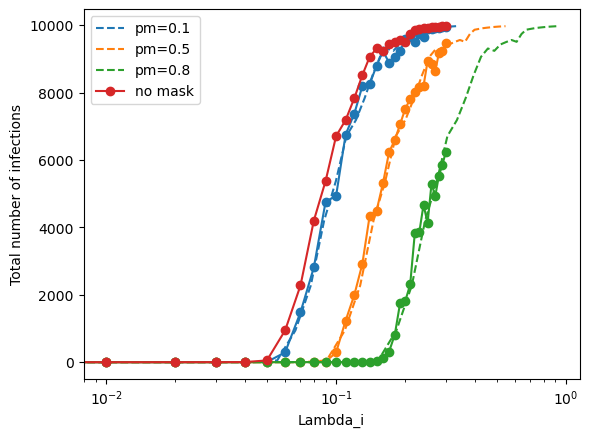

In [55]:
plt.figure()
color_scheme = ['tab:blue', 'tab:orange', 'tab:green']

for idx, pm in enumerate(pm_ary):
    plt.plot(lambda_ary_eff[idx], Nr_ary_nomask, '--', color = color_scheme[idx], label=f"pm={pm}")
    plt.plot(lambda_ary, Nr_arys_mask[idx], 'o-', color = color_scheme[idx])
plt.plot(lambda_ary, Nr_ary_nomask, 'o-', color = 'tab:red', label="no mask")
plt.xlabel("Lambda_i")
plt.xscale("log")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()